# Product Analytics

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
# from pyspark.sql.functions import rank,col,sum
# from pyspark.sql.functions import hour, dayofmonth, dayofweek, year, month, when
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType


from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, MinMaxScaler, OneHotEncoder
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

from xgboost.spark import SparkXGBClassifier


import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Build Spark Session
spark = SparkSession.builder \
    .appName("Product-Analytics") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

25/03/04 23:31:07 WARN Utils: Your hostname, Richards-MacBook-Pro-67.local resolves to a loopback address: 127.0.0.1; using 192.168.0.12 instead (on interface en0)
25/03/04 23:31:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/04 23:31:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Data pre-processing

In [4]:
# Read CSV into a Spark DF
df = spark.read.csv("product.csv",header=True,inferSchema=True)

In [5]:
num_rows = df.count()
print(f'Number of rows is {num_rows}')
df.printSchema()
df.show()

Number of rows is 8471220
root
 |-- order_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- page_id: string (nullable = true)
 |-- product: string (nullable = true)
 |-- site_version: string (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- target: integer (nullable = true)

+--------------------+--------------------+--------------------+----------------+------------+-------------------+------------+------+
|            order_id|             user_id|             page_id|         product|site_version|               time|       title|target|
+--------------------+--------------------+--------------------+----------------+------------+-------------------+------------+------+
|cfcd208495d565ef6...|c81e728d9d4c2f636...|6f4922f45568161a8...|        sneakers|     desktop|2019-01-11 09:24:43|banner_click|     0|
|c4ca4238a0b923820...|eccbc87e4b5ce2fe2...|4e732ced3463d06de...|        sneakers|     desktop|2019-01-09 09:38:5

In [6]:
df.select("title").distinct().show()
df.select("product").distinct().show()
df.select("site_version").distinct().show()

+------------+
|       title|
+------------+
| banner_show|
|banner_click|
|       order|
+------------+



+----------------+
|         product|
+----------------+
|        sneakers|
|sports_nutrition|
|         clothes|
|     accessories|
|         company|
+----------------+



+------------+
|site_version|
+------------+
|     desktop|
|      mobile|
+------------+



### Check for null values, duplicates, outliers in the DF

In [7]:
# Check for Null values 
df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()
# there is no null values

+--------+-------+-------+-------+------------+----+-----+------+
|order_id|user_id|page_id|product|site_version|time|title|target|
+--------+-------+-------+-------+------------+----+-----+------+
|       0|      0|      0|      0|           0|   0|    0|     0|
+--------+-------+-------+-------+------------+----+-----+------+



In [8]:
# Check for duplicate rows
total_rows = df.count()
distinct_rows = df.distinct().count()
if total_rows > distinct_rows:
    print(f"There are {total_rows - distinct_rows} duplicate rows.")
else:
    print("\n\n\n\nThere are no duplicate rows.")





There are no duplicate rows.


### Do some feature engineering

In [9]:
# Convert site version column to binary

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in [ "site_version"]]

for indexer in indexers:
    df = indexer.transform(df)


In [10]:
# Step 1: Get unique products
unique_products = df.select("product").distinct().rdd.flatMap(lambda x: x).collect()
# print("Unique Products:", unique_products)

# Step 2: Initialize columns of 0 for each product
for product in unique_products:
    df = df.withColumn(f"product_{product}", F.when(F.col("product") == product, 1).otherwise(0))


In [11]:
# Generate visit number for each row

# Define the window specification
window_spec = Window.partitionBy('user_id').orderBy('time')

# Apply the rank function within each group (user)
df = df.withColumn('visitNumber', F.rank().over(window_spec))

In [12]:
# Extracting time information

# 1. time_IsMorning (6:00 AM to 10:00 AM)
df = df.withColumn(
    'time_IsMorning', F.when((F.hour('time') >= 6) & (F.hour('time') < 10), 1).otherwise(0)
)

# 2. time_IsDaylight (10:00 AM to 4:00 PM)
df = df.withColumn(
    'time_IsDaylight', F.when((F.hour('time') >= 10) & (F.hour('time') < 16), 1).otherwise(0)
)

# 3. time_IsEvening (4:00 PM to 11:00 PM)
df = df.withColumn(
    'time_IsEvening', F.when((F.hour('time') >= 16) & (F.hour('time') < 23), 1).otherwise(0)
)

# 4. time_Hour (extract the hour)
df = df.withColumn(
    'time_Hour', F.hour('time')
)

# 5. time_Day (extract the day of the month)
df = df.withColumn(
    'time_Day', F.dayofmonth('time')
)

# 6. time_Week_Day (extract the weekday, starting from 1 for Monday)
df = df.withColumn(
    'time_Week_Day', (F.dayofweek('time') - 1).cast('int') + 1  # dayofweek returns 1 for Sunday, adjust to start from Monday as 1
)

# 7. time_Year_Month (create a YYYYMM format)
df = df.withColumn(
    'time_Year_Month', (F.year('time') * 100 + F.month('time')).cast('int')
)

### Drop columns

In [13]:
# Drop columns
df_final = df.drop("order_id", "page_id", "product", "site_version", "time", 
                   "title", "product_index", "user_id")

In [14]:
df_final.columns

['target',
 'site_version_index',
 'product_sneakers',
 'product_sports_nutrition',
 'product_clothes',
 'product_accessories',
 'product_company',
 'visitNumber',
 'time_IsMorning',
 'time_IsDaylight',
 'time_IsEvening',
 'time_Hour',
 'time_Day',
 'time_Week_Day',
 'time_Year_Month']

## Ok, let's do some analysis now

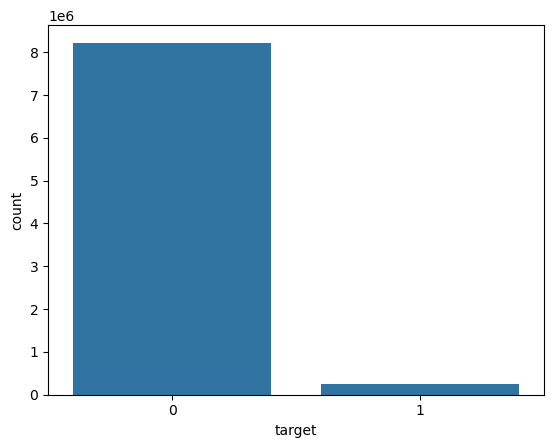

In [15]:
# Grouping by 'target' and counting occurrences
target_counts = df_final.groupBy('target').count().toPandas()

sns.barplot(x='target', y='count', data=target_counts)
plt.show()

### Class imbalance
There's a large class imbalance so we need to take that into account. We can either
1. Balance the data
2. Take the data into account by modifying loss function
   
I tend to not like balancing the data so I'll go with models of (2)

In [16]:
# Compute class weights (inverse frequency)

class_counts = df_final.groupBy("target").count().collect()
total_count = df_final.count()
class_weights = {row['target']: total_count / row['count'] for row in class_counts}

# Initialize df with weights
df_final = df_final.withColumn(
    "weight",
    F.when(F.col("target") == 0, class_weights[0])
    .otherwise(class_weights[1])
)

In [17]:
# Form feature vector from leftover stuff

# Define the list of columns to exclude
exclude_cols = ["target", "weight"]

# Get all columns except those in `exclude_cols`
feature_cols = [col for col in df_final.columns if col not in exclude_cols]

# Use VectorAssembler to combine the remaining columns into a feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform the DataFrame
df_final = assembler.transform(df_final)

## Logistic regression

In [18]:
# Logistic Regression with class weights
lr = LogisticRegression(labelCol="target", featuresCol="features", weightCol="weight")

# Train the model
model = lr.fit(df_final)

25/03/04 23:33:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/03/04 23:33:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [22]:
# Make predictions using the trained model
predictions = model.transform(df_final)

# Use BinaryClassificationEvaluator to evaluate AUC
evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction", metricName="areaUnderROC")

# Compute AUC
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

AUC: 0.7159544395841737


In [ ]:
model.coefficients

DenseVector([1.1749, 2.9021, 1.8571, 3.3061, 2.5038, -19.8217, 0.1697, -1.457, -0.9953, -1.0692, 0.0301, -0.0024, -0.0005, -0.0618])

In [19]:
feature_columns = assembler.getInputCols()
print("Feature columns used in the vector:", feature_columns)

Feature columns used in the vector: ['site_version_index', 'product_sneakers', 'product_sports_nutrition', 'product_clothes', 'product_accessories', 'product_company', 'visitNumber', 'time_IsMorning', 'time_IsDaylight', 'time_IsEvening', 'time_Hour', 'time_Day', 'time_Week_Day', 'time_Year_Month']


## XGBoost

In [27]:
# Define XGBoost Classifier
xgb = SparkXGBClassifier(features_col='features', label_col='target', weight_col="weight")

# Train the XGBoost model
xgb_model = xgb.fit(df_final)

# Make predictions using the trained model
predictions = xgb_model.transform(df_final)

2025-03-04 23:45:26,733 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-03-04 23:46:06,459 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[23:46:07] Task 0 got rank 0
2025-03-04 23:47:28,979 INFO XGBoost-PySpark: _fit Finished xgboost training!   


In [28]:
# Use BinaryClassificationEvaluator to evaluate AUC
evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction", metricName="areaUnderROC")

# Compute AUC
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

2025-03-05 00:01:23,268 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


AUC: 0.7410389012042662
